## Problem 1 - 1D unconstrained optimization

### (a). Write a functioning one-dimensional black box unconstrained function optimizer.

In [1]:
%matplotlib inline

In [2]:
import timeit
import numpy as np
import matplotlib
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True
import matplotlib.pyplot as plt
import seaborn as sns

Here we will use the Fibonacci method for optimization. Our function will return a couple of useful values:
* $x^*$
* $f(x^*)$
* number of function calls for $f(x)$

In [3]:
def fib_min(f, x_1, x_4, n):
    I_0 = np.abs(x_4 - x_1)  # Initial interval of uncertainty
    c = (np.sqrt(5) - 1) / 2
    s = (1 - np.sqrt(5)) / (1 + np.sqrt(5))
    alpha = (c*(1 - s**n)) / (1 - s**(n+1))
    x_3 = alpha*x_4 + (1 - alpha)*x_1
    f_3 = f(x_3)
    
    for i in range(1, n+1):
        x_2 = 0.01*x_1 + 0.99*x_3 if i == n else alpha*x_1 + (1 - alpha)*x_4
        
        f_2 = f(x_2)
        if f_2 < f_3:
            x_4 = x_3
            x_3 = x_2
            f_3 = f_2
        else:
            x_1 = x_4
            x_4 = x_2
        alpha = (c*(1 - s**(n-i))) / (1 - s**(n-i+1))
        
    x_star = np.median([x_1, x_2, x_3, x_4])
    f_star = f(x_star)
    ncalls = f.called()
    f.reset()
    return(x_star, f_star, ncalls)

### (b). Test code of part (a). on two different 1D unconstrained optimization problems, with optimization starting points drawn from a probability distribution.

First, let's create a little helper function to keep track of the number of function calls

In [4]:
# Helper function to count function calls
def count(f):
    def call(*args,**kargs):
        call.calls += 1
        return f(*args,**kargs)

    call.calls = 0
    def reset(): call.calls = 0 
    call.reset = reset
    call.called = lambda : call.calls
    return call

Let's make up some functions, $f(x)$, to optimize:
* $f_{1}(x) = x^2 + 2x \:$  (quadratic)
* $f_{2}(x) = x^3 - 13x^2 + 36 \:$  (non-quadratic)

Let's also plot the functions to have a general sense of the interval to use for our optimizer

In [5]:
@count
def f_1(x):
    return x**2 + 2*x

@count
def f_2(x):
    return x**3 - 3*x**2 + 36

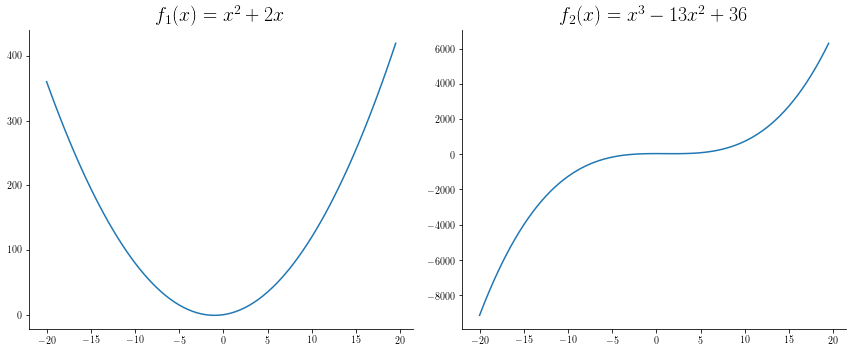

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
x1 = np.arange(-20, 20, 0.5)
x2 = np.arange(-20, 20, 0.5)

ax1.plot(x1, f_1(x1))
ax1.set_title(r"$f_{1}(x) = x^2 + 2x$", size=20)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

ax2.plot(x2, f_2(x2))
ax2.set_title(r'$f_{2}(x) = x^3 - 13x^2 + 36$', size=20)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

plt.tight_layout()

We now need to determine the starting points for our optimizer and determine the number of iterations or stopping conditions. For simplicity, let us obtain $x^*$ such that $f(x^*)$ is within $1\%$ of the true optimum.

$$\begin{aligned}
\frac{I_n}{2I_0} &\leq \frac{1}{100}\\
\frac{I_n}{I_0}  &\leq \frac{1}{50}\\
\frac{1}{F_n}    &\leq \frac{1}{50}\\
F_n              &\geq 50
\end{aligned}$$

Let us now obtain $n$ from the fibonacci sequence using Binet's formula

In [7]:
def fib(n):
    return (((1 + np.sqrt(5)) / 2)**n - ((1 - np.sqrt(5)) / 2)**n) / np.sqrt(5)

for n in range(2, 100):
    fib_n = fib(n)
    if fib_n >= 50:
        print('n = {}\nfib_n = {}'.format(n, fib_n))
        break

n = 10
fib_n = 55.000000000000014


Let us now create some random samples for our starting points. We'll draw from uniform distribution and sample from the interval $[-100, 100)$

In [8]:
# Set random seed
np.random.seed(23)

# Create samples
f1_samples = 10 * np.random.random_sample((10, 2)) - 5
f2_samples = 12 * np.random.random_sample((10, 2)) + 3

In [9]:
# Override template to get return value of our function
timeit.template = """
def inner(_it, _timer{init}):
    {setup}
    _t0 = _timer()
    for _i in _it:
        retval = {stmt}
    _t1 = _timer()
    return _t1 - _t0, retval
"""

We are all setup for running our simulation. Let us gather the results for $f_1$ and $f_2$. Finally we wan't to gather some basic statistics (i.e. mean, std. dev) and plot our results

In [10]:
n = 10
f1_setup = 'from __main__ import fib_min, f_1, s, n'
f1_test = 'fib_min(f_1, s[0], s[1], n)'
f1_results = []

for s in f1_samples:
    f1_results.append(timeit.timeit(stmt=f1_test, setup=f1_setup, number=1))

In [11]:
n = 10
f2_setup = 'from __main__ import fib_min, f_2, s, n'
f2_test = 'fib_min(f_2, s[0], s[1], n)'
f2_results = []

for s in f2_samples:
    f2_results.append(timeit.timeit(stmt=f2_test, setup=f2_setup, number=1))

In [12]:
f1_results

[(0.00031502999991062097, (0.22077300394550425, 0.49028672716213012, 13)),
 (0.00024079399736365303, (-0.98249375130626904, -0.99969353125667326, 12)),
 (0.0001586680009495467, (-1.0127280905781031, -0.99983799571023568, 12)),
 (0.00010602999827824533, (-1.1010168836285472, -0.98979558922197652, 12)),
 (0.00017196100088767707, (-0.85742344875455867, -0.97967192703495609, 12)),
 (0.0001428949981345795, (-1.0122604329506368, -0.99984968178386291, 12)),
 (0.00014444200132857077, (-1.0110553483683551, -0.99987777927245425, 12)),
 (0.00011154800085932948, (0.93907220274176495, 2.7600010074458003, 12)),
 (0.00016382700050598942, (-1.0179536161182714, -0.9996776676682777, 12)),
 (0.00011302100028842688, (-2.0533243498902616, 0.10949218607174238, 12))]

In [13]:
f2_results

[(0.00022136100233183242, (10.54079394554303, 873.8450749670269, 13)),
 (0.00015103700206964277, (3.0210220594762953, 36.191859387409764, 12)),
 (0.0001784939995559398, (4.8065037627030804, 77.734714195084393, 12)),
 (0.0001812189984775614, (7.1680507138878387, 250.15840964945352, 12)),
 (0.00013467199823935516, (8.2021122793723045, 385.97026123252982, 12)),
 (0.00013925299936090596, (11.629249583790283, 1203.0149320900232, 12)),
 (0.0001658469991525635, (4.4953778492096674, 66.219226636995614, 12)),
 (0.000117019000754226, (3.937485503019325, 50.534580322907622, 12)),
 (0.00011335199815221131, (8.6223334994902636, 453.99033173536924, 12)),
 (0.0001349949998257216, (4.9964498775371275, 85.840395684861249, 12))]

In [44]:
# Create matrix of results for easier computation
f1_mat = np.array([list([e[0], e[1][0], e[1][1], e[1][2]]) for e in f1_results])
f2_mat = np.array([list([e[0], e[1][0], e[1][1], e[1][2]]) for e in f2_results])

In [45]:
f1_mat = np.array(f1_mat)

In [46]:
np.median(f1_mat[:,2])

-0.99473662844512711

In [50]:
np.std(f1_mat[:,2])

1.1621137742108647

In [49]:
np.median(f2_mat[:,2])

167.99940266715737

In [51]:
np.std(f1_mat[:,2])

1.1621137742108647